#**Project Name: Fake News Detection and Evaluation with Confusion Matrix**
####**created by: Suprava Das**

# **Problem Statement:**


This project addresses the challenge of distinguishing fake news from true news using machine learning techniques. A classification model is trained on textual data, and its effectiveness is evaluated through a confusion matrix to assess accuracy and misclassification patterns.

# **Data Introduction:**

This dataset was compiled from real-world sources; the genuine articles were scraped from Reuters.com (a reputable news website). In contrast, the fake news articles were gathered from various unreliable platforms identified by Politifact (a U.S.-based fact-checking organization) and Wikipedia. The collection covers articles on diverse subjects, though most of them center around politics and world news.

The dataset cab also be downloaded from kaggle using the link: www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets

# **Import Packages**

Imported all required libraries and installed any missing packages in Google Colab.

In [ ]:
# installed missing package gensim
!pip install gensim

In [ ]:
# import necessary packages
import  matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# mounted the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Data Preprocessing**

In [ ]:
# read the csv file using pandas dataframe
fake_news_data = pd.read_csv('/content/drive/My Drive/IDEAS-TIH/Internship_2025/Fake.csv')
true_news_data = pd.read_csv('/content/drive/My Drive/IDEAS-TIH/Internship_2025/True.csv')

**Q1.** View the imported csv file data using Pandas Dataframe.

In [ ]:
fake_news_data["class"] = 1  # Fake News data → 1
true_news_data["class"] = 0  # True News data → 0

In [ ]:
# merged true and fake news datasets
merged_data = [fake_news_data,true_news_data]
df = pd.concat(merged_data,axis=0)

**Q2.** drop rows from the dataset consisting null values.

**Q3.** shuffle the data.

In [ ]:
#reset index of the merged dataframe
df = df.reset_index(drop=True)

In [ ]:
# view top 10 rows of processed dataset
df.head(10)

,title,text,subject,date,class
0,"Head of Zimbabwe election commission quits, so...",HARARE (Reuters) - Zimbabwe Electoral Commissi...,worldnews,"December 8, 2017",0
1,House Speaker Ryan plans Harvey aid 'installme...,WASHINGTON (Reuters) - U.S. House of Represent...,politicsNews,"September 1, 2017",0
2,SETH RICH MURDER Has CHILLING SIMILARITIES To ...,Just two months shy of the one-year anniversar...,left-news,"May 16, 2017",1
3,U.S. tax cuts won't make housing more affordab...,(Reuters) - The U.S. tax overhaul as currently...,politicsNews,"December 19, 2017",0
4,Bill Maher Shows America Why Donald Trump Mus...,Bill Maher is not shy about what he thinks of ...,News,"May 7, 2016",1
5,BREAKING! INVESTIGATION: Hillary Clinton Did N...,Was Hillary Clinton negligent or was she doin...,Government News,"May 25, 2016",1
6,China considers three-year jail terms for disr...,BEIJING (Reuters) - China s largely rubber-sta...,worldnews,"October 31, 2017",0
7,Trump administration blacklists three official...,WASHINGTON (Reuters) - The Trump administratio...,worldnews,"September 6, 2017",0
8,Watch NBC’s Andrea Mitchell Get BULLIED Out O...,"If one thing has become abundantly clear, it s...",News,"March 7, 2017",1
9,New York protesters camp out at Goldman Sachs ...,NEW YORK (Reuters) - Dozens of protesters gath...,politicsNews,"January 18, 2017",0


**Q4.** view the text content of a random data point.

**Data Visualization**

Text(0, 0.5, 'Number of News')

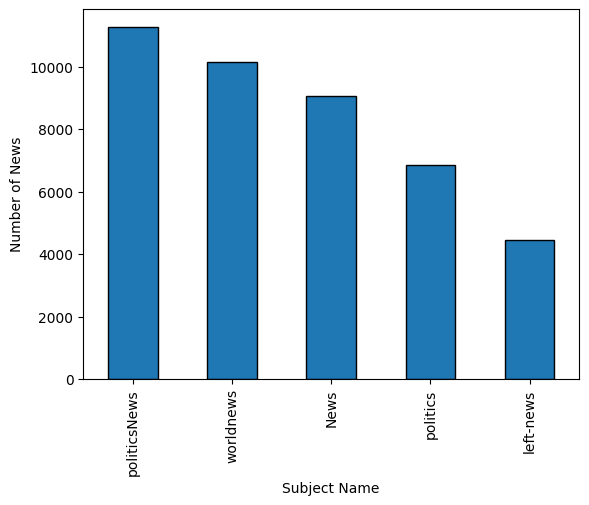

In [ ]:
#create a data visualzation of bar/column/line chart of top 5 subjects ->
top_5_subjects = (df['subject'].value_counts()).nlargest(5)
top_5_subjects.plot(kind='bar', edgecolor='black', stacked=True)
plt.xlabel('Subject Name')
plt.ylabel('Number of News')

**Q5.** Create a pie chart to find the pecentage of news on differenet subject.

**Text Processing**

In [ ]:
# function to remove space,special charecter and convert all text into lower case
def wordopt(text):
  text = text.lower()
  text= re.sub(r'https://\S+|www\.\S+','',text) # remove https:// or www.com
  text = re.sub(r'[^\w]',' ', text) #remove special charecter
  text= re.sub(r'\s+',' ',text) #remove multiple space

  return text

In [ ]:
# drop unnecessary columns for classification purpose
df1= df.drop(['title','subject','date'],axis=1)

In [ ]:
# apply wordopt method to the whole dataset and view the text content of a random data point
df1['text']=df1['text'].apply(wordopt)
df1['text'][100]

'donald trump has been in office for several months now and he still hasn t figured out the proper way to respond to a terrorist attack trump demonstrated his idiocy to the world earlier this week when he responded to the terrorist attack in london by using the tragedy as an opportunity to promote his muslim travel ban trump got blasted on social media for his disgusting insensitive response but top democrat nancy pelosi found the perfect way to slam trump by actually showing him how he should have responded unlike trump pelosi didn t blame london s mayor or use it to promote any agenda her response was completely presidential and serves as a perfect example of how trump should behave while completely humiliating him at the same time in a beautiful statement of solidarity pelosi said today the american people stand in solidarity with the people of the united kingdom and share in the shock and outrage of this brutal attack we send our thoughts and prayers to the fallen the injured and t

# **Building Model**

In [ ]:
# Separate independent and target columns from the dataset and stored them in x & y variables
x= df1['text']
y= df1['class']

**Q6.** Split the dataset into training and testing sets with 25% test size and store them in x_train, x_test, y_train, and y_test.

## **Word Embedding ( Word2Vec )**

In [ ]:
# import bbc_news data using url link in json format for training Word2Vec word embedding model
news = pd.read_json('https://query.data.world/s/7c6p2lxb3wjibfsfbp4mwy7p7y4y2d?dws=00000')
news_seg = news['content']
print("Size of Word Dictonary for training Word2Vec: ",news_seg.shape[0])
news_seg.head(2)

Size of Word Dictonary for training Word2Vec:  15825


,content
0,The heroin substitute methadone can be used as...
1,The eldest son of North Korean leader Kim Jong...


In [ ]:
# apply wordopt function for text processing
news_seg=news_seg.apply(wordopt)
sentences = [sentence.split() for sentence in news_seg ]
w2v_model = Word2Vec(sentences,  window=5, min_count=5, workers=4)

In [ ]:
# function to convert a sentence into vector form
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [ ]:
# convert train and test dataset into vector form
xv_train = np.array([vectorize(sentence) for sentence in x_train])
xv_test = np.array([vectorize(sentence) for sentence in x_test])

##**Logistic Regression**

In [ ]:
# Trains a Logistic Regression model using vector formed trained data ->
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression()
logistic_model.fit(xv_train,y_train)

LogisticRegression()

In [ ]:
# detect the class(fake or true) on test data and evaluates its accuracy on test set
y_pred = logistic_model.predict(xv_test)
print("Prediction on test data: ",y_pred)
print("Accuracy Score on Test Data: ",logistic_model.score(xv_test,y_test))

Prediction on test data:  [1 1 1 ... 1 1 0]
Accuracy Score on Test Data:  0.9387973273942094


####**Accuracy Checking**

In [ ]:
# Check Precision, Recall, F1 Score of the logistic model ->
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))

Accuracy: 0.9387973273942094
Precision: 0.9442124603307166
Recall: 0.9412254412254413
F1 score: 0.9427165846743933


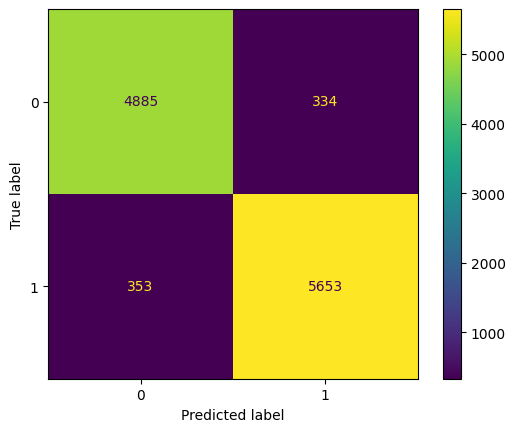

In [ ]:
# Check overall accuracy using confusion matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm= confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()

##**Random Forest Classifier**

####**Model Building and Prediction**

**Q7.** Use Random Forest Classifer for this classfication purpose and predict the outcomes for test data.

####**Accuracy Checking**

**Q8.** Find the accuracy, precison, recall, F1 Score of the model while using Random Forest Classsifier and visualize overall accuracy using confusion matrix.

#**Save the Model using pickle**

In [ ]:
# save the logistic regression model as pickle file
import pickle
filename1 = '/content/drive/My Drive/IDEAS-TIH/Internship_2025/word2vec_logistic_model.pickle'
pickle.dump(logistic_model, open(filename1, 'wb')) #word2vec model

In [ ]:
# Load the pickle file and checkout model score
loaded_model = pickle.load(open(filename1, 'rb'))
result = loaded_model.score(xv_test, y_test)
print(result)

0.9387973273942094


**Q9.** Save the trained Random Forest Model as pickle/svg file in your desired repository for further use.

**Q10.** Load that saved model in another Notebook use it on other dataset for fake news detection.

**Q11(Optional).**


1.  Try to enhance the model's accuracy by using adaboost or any other boosting methods.
2.  Use TF-IDF or any other vectorizer instead of Word2Vec and study how much it affects on model's accuracy.




